# Define Imports

In [9]:
import json
import os
import tensorflow as tf
import numpy as np
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
import argparse

# Change dir in jupyter notebook

In [10]:
#dvc-cc-hide
if os.getcwd().endswith('source'):
    os.chdir('..')

# Define Argparser

In [11]:
print()
print('Tensorflow runs on the GPU: ', tf.config.list_physical_devices('GPU'))
print()
parser = argparse.ArgumentParser();


Tensorflow runs on the GPU:  []



In [12]:
# define the training
parser.add_argument('-lr', '--learning-rate', type=float, help='', default=0.0001)
parser.add_argument('-b','--batch-size', type=int, help='', default=64)
parser.add_argument('--num-of-epochs', type=int, help='', default=1000);

In [13]:
# define the model structure
parser.add_argument('--activation-function', type=str, help='', default='relu')
parser.add_argument('--kernel-width', type=int, help='', default=3)
parser.add_argument('--average-kernels', type=int, help='', default=32)
parser.add_argument('--num-of-conv-layers', type=int, help='', default=5)
parser.add_argument('--kernel-increasing-factor', type=float, help='', default=1.2)
parser.add_argument('--maxpool-after-n-layer', type=int, help='', default=0)
parser.add_argument('--dropout-factor-after-conv', type=float, help='', default=0.1)
parser.add_argument('--dropout-factor-after-maxp', type=float, help='', default=0.25);

In [14]:
"""dvc-cc-show
args = parser.parse_args()
""";

In [15]:
#dvc-cc-hide
args = parser.parse_args("--num-of-epochs 5 -b 16".split())

# Define the model

In [16]:
# define the model
padding = 'same'

In [17]:
kernel2d = (args.kernel_width, args.kernel_width)

In [18]:
model = Sequential()
for i in range(args.num_of_conv_layers):
    kernels = args.average_kernels * (args.kernel_increasing_factor ** (i-(args.num_of_conv_layers/2.)))
    kernels = int(kernels+0.5)
    
    if i == 0:
        input_shape = list([96,96,3])
        # use_cropping:
        input_shape[0] -= 10
        input_shape[1] -= 10 
        
        model.add(Conv2D(kernels, kernel2d, padding=padding,
                 input_shape=input_shape))
    else:
        model.add(Conv2D(kernels, kernel2d, padding=padding))
    model.add(Activation(args.activation_function))
    if args.maxpool_after_n_layer > 0 and (i+1) % args.maxpool_after_n_layer == 0:
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if args.dropout_factor_after_maxp > 0:
            model.add(Dropout(args.dropout_factor_after_maxp))
    elif args.dropout_factor_after_conv > 0:
        model.add(Dropout(args.dropout_factor_after_conv))

model.add(GlobalAveragePooling2D())
if args.dropout_factor_after_maxp > 0:
    model.add(Dropout(args.dropout_factor_after_maxp))


model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = tf.keras.optimizers.Adam(args.learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 20)        560       
_________________________________________________________________
activation (Activation)      (None, 86, 86, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 86, 86, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 86, 24)        4344      
_________________________________________________________________
activation_1 (Activation)    (None, 86, 86, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 86, 86, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 29)        6

# Define Data Loader

In [19]:
def next_data_pcam(x_path,y_path,bz=args.batch_size):
    x = h5py.File(x_path,'r', libver='latest',swmr=True)['x']
    y = h5py.File(y_path,'r', libver='latest', swmr=True)['y']

    datalen = len(x)
    while True:
        indizies = None
        while indizies is None or len(indizies) == bz:
            indizies = list(np.unique(sorted(np.random.randint(datalen,size=bz))))
        
        x_data = np.array(x[indizies])
        
        # normalize_input
        x_data = x_data/256.0
        
        #use_cropping
        r = np.random.randint(10)
        r2 = np.random.randint(10)
        x_data = x_data[:,r:-10+r,r2:-10+r2]
        
        # flip_input
        if np.random.randint(2) == 1:
            x_data = x_data[:,::-1]
        if np.random.randint(2) == 1:
            x_data = x_data[:,:,::-1]
        
        yield x_data, np.array([[1,0],[0,1]])[y[indizies][:,0,0,0]]

# Train the model

In [20]:
tensorboard = tf.keras.callbacks.TensorBoard('tensorboard')
history = model.fit_generator(next_data_pcam(
                             'data/camelyonpatch_level_2_split_train_x.h5',
                             'data2/camelyonpatch_level_2_split_train_y.h5'),
                        validation_steps=10,
                        steps_per_epoch=30,
                        epochs=args.num_of_epochs,
                        validation_data=next_data_pcam(
                             'data3/camelyonpatch_level_2_split_valid_x.h5',
                             'data4/camelyonpatch_level_2_split_valid_y.h5'),
                        workers=1,
                        verbose=2,
                        use_multiprocessing=False,
                        callbacks=[tensorboard])

model.save_weights('tf_model.h5')


W0315 13:48:58.825515 140515637122880 deprecation.py:323] From <ipython-input-20-5d8a99539cb9>:14: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W0315 13:48:59.316424 140515637122880 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0315 13:48:59.458796 140515637122880 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 30 steps, validate for 10 steps
Epoch 1/5
30/30 - 16s - loss: 0.6952 - accuracy: 0.4756 - auc: 0.4752 - val_loss: 0.6932 - val_accuracy: 0.5400 - val_auc: 0.4893
Epoch 2/5
30/30 - 12s - loss: 0.6913 - accuracy: 0.5244 - auc: 0.5418 - val_loss: 0.6907 - val_accuracy: 0.4467 - val_auc: 0.5711
Epoch 3/5
30/30 - 12s - loss: 0.6907 - accuracy: 0.5089 - auc: 0.5323 - val_loss: 0.6896 - val_accuracy: 0.4933 - val_auc: 0.6540
Epoch 4/5
30/30 - 13s - loss: 0.6895 - accuracy: 0.5667 - auc: 0.5773 - val_loss: 0.6867 - val_accuracy: 0.5200 - val_auc: 0.6258
Epoch 5/5
30/30 - 13s - loss: 0.6863 - accuracy: 0.5378 - auc: 0.5606 - val_loss: 0.6800 - val_accuracy: 0.7000 - val_auc: 0.7514


# Save output files

In [21]:
if not os.path.exists('outputs'):
    os.mkdir('outputs')

In [22]:
with open('outputs/all-history.json','w') as f:
    json.dump(str(history.history),f)

params = {}
for p in history.history:
    if p.find('loss') >= 0:
        params[p] = np.min(history.history[p])
    else:
        params[p] = np.max(history.history[p])
        
with open('outputs/history-summary.json','w') as f:
    json.dump(str(params),f)

In [23]:
# RANDOM STOFF

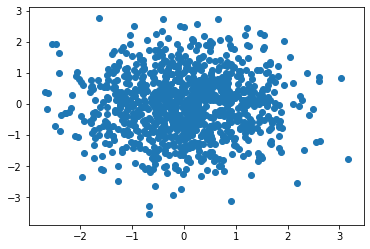

In [24]:
import matplotlib.pyplot as plt
loss = history.history['loss']
plt.plot(range(len(loss)), loss)

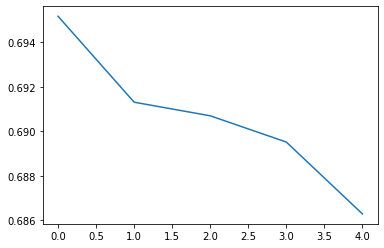